In [20]:
# ==============================
# 📌 1. Import Library
# ==============================
import os
import shutil
import random
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import tkinter as tk
from tkinter import filedialog, ttk
from PIL import Image, ImageTk
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import load_img, img_to_array


In [21]:
# ==============================
# 📌 2. PREPROCESSING DATASET
# ==============================

# Path dataset awal
base_dir = "B:\Belajar\SEMESTER 6\Analisis Citra\Final Project\TRAIN"
output_dir = "B:\Belajar\SEMESTER 6\Analisis Citra\Final Project\TRAIN_BALANCED"

# Path folder Batik Madura dan Batik Non-Madura
madura_dir = os.path.join(base_dir, "Batik Madura")
non_madura_dir = os.path.join(base_dir, "Batik Non Madura")

# Path folder output
madura_out = os.path.join(output_dir, "Madura")
non_madura_out = os.path.join(output_dir, "Non-Madura")

# Buat folder output jika belum ada
os.makedirs(madura_out, exist_ok=True)
os.makedirs(non_madura_out, exist_ok=True)

# **1. Pilih 840 gambar dari Batik Madura**
madura_images = [f for f in os.listdir(madura_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
selected_madura = random.sample(madura_images, min(840, len(madura_images)))

# Copy gambar ke folder baru
for img in selected_madura:
    shutil.copy(os.path.join(madura_dir, img), os.path.join(madura_out, img))

print(f"✅ 840 gambar Batik Madura telah dipilih dan disimpan di {madura_out}")

# **2. Pilih 60 gambar dari setiap subfolder di Batik Non-Madura**
non_madura_folders = [f for f in os.listdir(non_madura_dir) if os.path.isdir(os.path.join(non_madura_dir, f))]

for folder in non_madura_folders:
    folder_path = os.path.join(non_madura_dir, folder)
    images = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    # Pilih 60 gambar acak dari setiap folder
    selected_images = random.sample(images, min(60, len(images)))
    
    for img in selected_images:
        shutil.copy(os.path.join(folder_path, img), os.path.join(non_madura_out, f"{folder}_{img}"))

print(f"✅ 840 gambar Batik Non-Madura telah dipilih dan disimpan di {non_madura_out}")
print("✅ Dataset sudah seimbang dan siap digunakan untuk training!")

✅ 840 gambar Batik Madura telah dipilih dan disimpan di B:\Belajar\SEMESTER 6\Analisis Citra\Final Project\TRAIN_BALANCED\Madura
✅ 840 gambar Batik Non-Madura telah dipilih dan disimpan di B:\Belajar\SEMESTER 6\Analisis Citra\Final Project\TRAIN_BALANCED\Non-Madura
✅ Dataset sudah seimbang dan siap digunakan untuk training!


In [22]:
# ==============================
# 📌 3. Fungsi Preprocessing Gambar
# ==============================
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def binarize(image):
    gray = grayscale(image)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    return binary

def minutiae_points(image):
    bin_img = binarize(image)
    kernel = np.ones((3, 3), np.uint8)
    img_thin = cv2.ximgproc.thinning(bin_img)
    minutiae = []
    for y in range(1, img_thin.shape[0] - 1):
        for x in range(1, img_thin.shape[1] - 1):
            if img_thin[y, x] == 255:
                neighborhood = img_thin[y-1:y+2, x-1:x+2].flatten()
                count = np.count_nonzero(neighborhood == 255)
                if count == 2 or count >= 4:
                    minutiae.append((x, y))
    return len(minutiae)

In [23]:
# ==============================
# 📌 4. Load Dataset dengan Augmentasi
# ==============================
base_dir = "B:\Belajar\SEMESTER 6\Analisis Citra\Final Project\TRAIN_BALANCED"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 5521 images belonging to 2 classes.
Found 1379 images belonging to 2 classes.


In [24]:
# ==============================
# 📌 5. Model CNN
# ==============================
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# ==============================
# 📌 6. Callbacks
# ==============================
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [26]:
# ==============================
# 📌 7. Train Model
# ==============================
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[reduce_lr]
)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.8662 - loss: 0.4218 - val_accuracy: 0.8687 - val_loss: 0.3636 - learning_rate: 1.0000e-04
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 119s 690ms/step - accuracy: 0.8657 - loss: 0.3832 - val_accuracy: 0.8687 - val_loss: 0.3272 - learning_rate: 1.0000e-04
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 138s 796ms/step - accuracy: 0.8674 - loss: 0.3670 - val_accuracy: 0.8687 - val_loss: 0.3327 - learning_rate: 1.0000e-04
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 109s 628ms/step - accuracy: 0.8708 - loss: 0.3446 - val_accuracy: 0.8687 - val_loss: 0.3094 - learning_rate: 1.0000e-04
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 110s 633ms/step - accuracy: 0.8601 - loss: 0.3546 - val_accuracy: 0.8687 - val_loss: 0.3090 - learning_rate: 1.0000e-04
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 121s 697ms/step - accuracy: 0.8705 - loss: 0.3241 - val_accuracy: 0.8658 - val_loss: 0.2942 - learning_rate: 1.0000e-04
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 98s

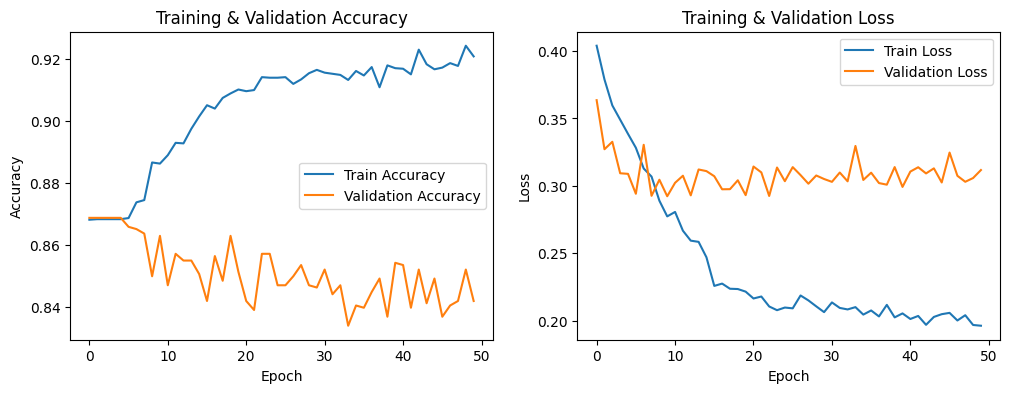

In [27]:
# ==============================
# 📌 8. Evaluasi Model
# ==============================
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
# ==============================
# 📌 9. Simpan Model & History
# ==============================
model.save("model/batik_madura_cnn.h5")
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("✅ Model telah disimpan!")


✅ Model telah disimpan!


In [29]:
# ==============================
# 📌 10. Load Model
# ==============================
model = load_model("model/batik_madura_cnn.h5")

In [30]:
# ==============================
# 📌 11. Fungsi Prediksi Gambar
# ==============================
def predict_image(img_path):
    image = cv2.imread(img_path)
    image = cv2.resize(image, (128, 128))
    image_array = np.expand_dims(image / 255.0, axis=0)
    prediction = model.predict(image_array)[0][0]

    minutiae_count = minutiae_points(image)
    jenis = "Batik Tulis" if minutiae_count > 30 else "Batik Cap"

    if prediction > 0.7:
        asal = "Batik Madura"
    else:
        asal = "Batik Non-Madura"

    return f"{asal} - {jenis}"

In [31]:
# ==============================
# 📌 12. GUI dengan Tkinter
# ==============================
class BatikClassifierApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Batik Classifier")
        self.root.geometry("800x600")
        self.root.configure(bg="#2C3E50")

        self.label_title = tk.Label(root, text="Batik Classifier", font=("Arial", 16, "bold"), bg="#2C3E50", fg="white")
        self.label_title.pack(pady=10)

        self.frame = tk.Frame(root, bg="#34495E", padx=20, pady=20)
        self.frame.pack(pady=10)

        self.btn_upload = tk.Button(self.frame, text="Upload Gambar", command=self.upload_image, font=("Arial", 12), bg="#1ABC9C", fg="white")
        self.btn_upload.pack()

        self.label_image = tk.Label(self.frame, text="Gambar akan muncul di sini", bg="#34495E", fg="white")
        self.label_image.pack(pady=10)

        self.label_result = tk.Label(root, text="Hasil Prediksi: ", font=("Arial", 14), bg="#2C3E50", fg="white")
        self.label_result.pack(pady=10)

    def upload_image(self):
        file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg;*.png;*.jpeg")])
        if file_path:
            img = Image.open(file_path)
            img = img.resize((200, 200))
            img_tk = ImageTk.PhotoImage(img)
            self.label_image.config(image=img_tk)
            self.label_image.image = img_tk

            result = predict_image(file_path)
            self.label_result.config(text=f"Hasil Prediksi: {result}")

# ==============================
# 📌 13. Jalankan GUI
# ==============================
if __name__ == "__main__":
    root = tk.Tk()
    app = BatikClassifierApp(root)
    root.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
